<a href="https://colab.research.google.com/github/asyraffff/Cardiac-Lengh-Of-Stay/blob/main/Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set()

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [56]:
df_patient = pd.read_csv("drive/My Drive/FYP_LOS/dataset/patient.csv", low_memory=False)
df_apacheApsVar = pd.read_csv("drive/My Drive/FYP_LOS/dataset/apacheApsVar.csv", low_memory=False)
df_apachePredVar = pd.read_csv("drive/My Drive/FYP_LOS/dataset/apachePredVar.csv", low_memory=False)

## Cohort selection

Selecting all ED-stays that had Cardiac-related diagnosis as their main (APACHE) admission diagnosis:

In [57]:
[i for i in df_patient.apacheadmissiondx.value_counts().index.to_numpy() if "cardiac" in i]

['Coma/change in level of consciousness (for hepatic see GI, for diabetic see Endocrine, if related to cardiac arrest, see CV)',
 'Arrest, respiratory (without cardiac arrest)',
 'Ablation or mapping of cardiac conduction pathway',
 'Chest pain, atypical (noncardiac chest pain)',
 'Defibrillator, automatic implantable cardiac; insertion of',
 'Tumor removal, intracardiac']

In [58]:
# cardiac patient
# but still the admission is not fully from Emergency department
# we will name the df "mix cardiac"
df_pat_card_mix = df_patient[df_patient['apacheadmissiondx'].str.contains('|'.join(['chf', 'congestive', '⁠rhythm disturbance',
                                                                  'atrial', 'cabg', 'myocardial', 'cardiac',
                                                                  'cardio', 'coronary', 'angina', 'heart',
                                                                   'chest',  'pulmonary edema']),
                                                        na=False, case=False)].copy()
# list of cardiac patients
lst_pat = df_pat_card_mix.patientunitstayid.to_list()
len(lst_pat)

44463

→ 44463 ICU-admissions with a primary diagnosis of Cardiac

In [59]:
# patients admitted from emergency department
df_pat_card_ed = df_pat_card_mix[df_pat_card_mix['hospitaladmitsource'] == "Emergency Department"].copy()

# list of patients
lst_pat = df_pat_card_ed.patientunitstayid.to_list()
len(lst_pat)

16930

→ 16930 ED-admissions with a primary diagnosis of Cardiac

## Data extraction

### Patient Data

Contains patient demographics and admission and discharge details for hospital and ED stays

In [60]:
df_pat_card_ed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16930 entries, 9 to 200856
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          16930 non-null  int64  
 1   patienthealthsystemstayid  16930 non-null  int64  
 2   gender                     16917 non-null  object 
 3   age                        16928 non-null  object 
 4   ethnicity                  16614 non-null  object 
 5   hospitalid                 16930 non-null  int64  
 6   wardid                     16930 non-null  int64  
 7   apacheadmissiondx          16930 non-null  object 
 8   admissionheight            16546 non-null  float64
 9   hospitaladmittime24        16930 non-null  object 
 10  hospitaladmitoffset        16930 non-null  int64  
 11  hospitaladmitsource        16930 non-null  object 
 12  hospitaldischargeyear      16930 non-null  int64  
 13  hospitaldischargetime24    16930 non-null  ob

In [61]:
# Column selection
df_pat_card_ed = df_pat_card_ed[['patientunitstayid', 'gender', 'age', 'ethnicity', 'apacheadmissiondx',
                                  'admissionheight', 'admissionweight',
                                  'hospitaladmitoffset','unitdischargeoffset', 'unitvisitnumber']]

In [62]:
# Gender has an unknown values
df_pat_card_ed['gender'].value_counts()

Male       9673
Female     7238
Unknown       6
Name: gender, dtype: int64

In [63]:
# Create a Length of Stay column
df_pat_card_ed['LOS_min'] = df_pat_card_ed['unitdischargeoffset'] - df_pat_card_ed['hospitaladmitoffset']
df_pat_card_ed = df_pat_card_ed.drop(['unitdischargeoffset', 'hospitaladmitoffset'], axis=1)

# Convert minutes to days
df_pat_card_ed['LOS'] = df_pat_card_ed['LOS_min'] / (24 * 60)
df_pat_card_ed['LOS'] = df_pat_card_ed['LOS'].apply(math.ceil)  # Round up to the nearest whole number
df_pat_card_ed = df_pat_card_ed.drop(['LOS_min'], axis=1)

# gender column
df_pat_card_ed["gender"] = df_pat_card_ed["gender"].replace({"Unknown": np.nan, "Other": np.nan})

# age column
df_pat_card_ed["age"] = df_pat_card_ed["age"].replace("> 89", "90")
df_pat_card_ed["age"] = pd.to_numeric(df_pat_card_ed["age"])

# weight columns
df_pat_card_ed.loc[(df_pat_card_ed.admissionweight <= 20) | (df_pat_card_ed.admissionweight >= 300),
                   ["admissionweight"]] = np.nan

# admissionheight
df_pat_card_ed.loc[(df_pat_card_ed.admissionheight < 100) | (df_pat_card_ed.admissionheight > 210),
                   ["admissionheight"]] = np.nan

# filter 'unitvisitnumber' more than 1 ED Stay
df_pat_card_ed = df_pat_card_ed[df_pat_card_ed['unitvisitnumber'] <= 1]
df_pat_card_ed = df_pat_card_ed.drop(['unitvisitnumber'], axis=1)

# len(df_pat_card_ed)
df_pat_card_ed.describe(include="all")

,patientunitstayid,gender,age,ethnicity,apacheadmissiondx,admissionheight,admissionweight,LOS
count,1.500200e+04,14984,15001.000000,14717,15002,14581.000000,14495.000000,15002.000000
unique,NaN,2,NaN,6,43,NaN,NaN,NaN
top,NaN,Male,NaN,Caucasian,"Infarction, acute myocardial (MI)",NaN,NaN,NaN
freq,NaN,8517,NaN,11372,3323,NaN,NaN,NaN
mean,1.638813e+06,NaN,64.983934,NaN,NaN,170.040857,86.669612,3.245367
std,9.969167e+05,NaN,15.735139,NaN,NaN,10.946221,26.998869,3.669317
min,1.412290e+05,NaN,13.000000,NaN,NaN,103.000000,24.900000,-5.000000
25%,8.381055e+05,NaN,55.000000,NaN,NaN,162.600000,68.500000,1.000000
50%,1.517125e+06,NaN,66.000000,NaN,NaN,170.200000,82.100000,2.000000
75%,2.598199e+06,NaN,77.000000,NaN,NaN,177.800000,99.800000,4.000000


### ApacheApsVar data

Contains the variables used to calculate the **Acute Physiology Score (APS) III** for patients. APS-III is an established method of **summarizing patient severity of illness** on admission to the ICU, and is a part of the **Acute Physiology Age Chronic Health Evaluation (APACHE)** system of equations for predicting outcomes for ICU patients.

In [64]:
df_apacheApsVar.head()

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,2,141168,0,0,0,4,6,5,0,-1.0,14.7,36.1,30.0,139.0,140,62.0,-1.00,40.1,2.30,3.1,-1.0,-1.0,27.0,95.0,4.1,-1.0
1,2399659,141178,0,0,0,-1,-1,-1,-1,-1.0,-1.0,36.4,16.0,-1.0,88,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,167885,141194,0,0,0,3,6,4,0,-1.0,14.1,39.3,36.0,134.0,118,40.0,-1.00,27.4,2.51,2.3,-1.0,-1.0,31.0,168.0,0.4,-1.0
3,70691,141197,0,0,0,4,6,5,0,-1.0,-1.0,-1.0,25.0,-1.0,104,-1.0,-1.00,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2279689,141203,0,1,0,1,3,1,0,-1.0,12.7,35.1,33.0,145.0,120,46.0,7.45,36.9,0.56,-1.0,51.0,37.0,9.0,145.0,-1.0,100.0


In [65]:
# drop columns that are not required
df_apacheApsVar = df_apacheApsVar.drop(['apacheapsvarid','meds'],axis=1)

# create the GCS column
df_apacheApsVar["GCS"] = df_apacheApsVar.eyes + df_apacheApsVar.motor + df_apacheApsVar.verbal

In [66]:
df_apacheApsVar.describe(include='all')

,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,GCS
count,1.711770e+05,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000
mean,1.747701e+06,0.148373,0.241551,0.036857,3.346215,5.273454,3.860676,893.177655,8.905202,33.728719,24.784735,108.366800,98.667993,85.058000,0.906831,24.716856,0.999311,0.509275,29.041982,9.020404,20.681516,141.184455,-0.210932,12.794373,12.480345
std,9.988850e+05,0.355470,0.428025,0.188410,1.214085,1.693745,1.754930,1637.209886,9.100861,9.725657,15.301895,57.117164,33.263814,42.970431,3.506569,15.452859,1.852455,1.933294,68.702746,19.510682,22.618132,109.723423,1.807201,28.329034,4.391875
min,1.411680e+05,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-11245.564800,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-3.000000
25%,9.555340e+05,0.000000,0.000000,0.000000,3.000000,6.000000,3.000000,-1.000000,-1.000000,36.100000,10.000000,129.000000,84.000000,53.000000,-1.000000,19.300000,0.470000,-1.000000,-1.000000,-1.000000,7.000000,85.000000,-1.000000,-1.000000,12.000000
50%,1.670376e+06,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,-1.000000,8.300000,36.400000,27.000000,137.000000,104.000000,65.000000,-1.000000,29.700000,0.810000,-1.000000,-1.000000,-1.000000,15.000000,115.000000,-1.000000,-1.000000,15.000000
75%,2.743419e+06,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,1420.761600,13.400000,36.700000,35.000000,140.000000,120.000000,123.000000,-1.000000,35.900000,1.360000,2.600000,-1.000000,-1.000000,28.000000,187.000000,0.500000,-1.000000,15.000000
max,3.353263e+06,1.000000,1.000000,1.000000,4.000000,6.000000,5.000000,269323.747200,198.100000,42.300000,60.000000,195.000000,220.000000,200.000000,7.810000,72.700000,24.950000,7.400000,636.000000,147.300000,254.000000,2357.000000,60.200000,100.000000,15.000000


### ApachePredVar data

Provides variables underlying the **APACHE predictions**. Acute Physiology Age Chronic Health Evaluation (APACHE) consists of a groups of equations used for predicting outcomes in critically ill patients

In [67]:
df_apachePredVar.head()

,apachepredvarid,patientunitstayid,sicuday,saps3day1,saps3today,saps3yesterday,gender,teachtype,region,bedcount,admitsource,graftcount,meds,verbal,motor,eyes,age,admitdiagnosis,thrombolytics,diedinhospital,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,electivesurgery,activetx,readmit,ima,midur,ventday1,oobventday1,oobintubday1,diabetes,managementsystem,var03hspxlos,pao2,fio2,ejectfx,creatinine,dischargelocation,visitnumber,amilocation,day1meds,day1verbal,day1motor,day1eyes,day1pao2,day1fio2
0,1794895,141168,1,0,0,0,1,0,3,12,7,3,0,5,6,4,70.0,RHYTHATR,0,1,0,0,0,0,0,0,0,NaN,1,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,2.30,9,1,-1,0,5,6,4,-1.0,-1.0
1,2406430,141178,1,0,0,0,1,0,3,9,8,3,-1,-1,-1,-1,52.0,NaN,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,-1.00,4,1,-1,-1,-1,-1,-1,-1.0,-1.0
2,1790923,141194,1,0,0,0,0,0,3,38,4,3,0,4,6,3,68.0,SEPSISUTI,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,-1.0,-1.0,-1,2.51,4,1,-1,0,4,6,3,-1.0,-1.0
3,27799,141197,1,0,0,0,0,0,3,30,8,3,0,5,6,4,71.0,SEPSISPULM,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,1,0,-1.0,-1.0,-1,-1.00,4,1,-1,0,5,6,4,-1.0,-1.0
4,2406432,141203,1,0,0,0,1,0,3,18,4,3,0,1,3,1,77.0,RESPARREST,0,0,0,0,0,0,0,0,0,NaN,1,0,0,0,1,1,0,1,1,0,51.0,100.0,-1,0.56,4,1,-1,0,1,3,1,51.0,100.0


In [68]:
df_apachePredVar = df_apachePredVar[['patientunitstayid', 'thrombolytics', 'aids', 'hepaticfailure',
                        'lymphoma', 'metastaticcancer', 'cirrhosis', 'diabetes']]

In [69]:
df_apachePredVar.describe(include='all')

,patientunitstayid,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.711770e+05,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000,171177.000000
mean,1.747701e+06,0.016194,0.001110,0.015878,0.004545,0.021118,0.018443,0.229634
std,9.988850e+05,0.126221,0.033298,0.125005,0.067263,0.143780,0.134547,0.420598
min,1.411680e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.555340e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.670376e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.743419e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.353263e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Merging data

In [70]:
df_cardiac = pd.merge(left = df_pat_card_ed, right = df_apacheApsVar, how='left', on="patientunitstayid")

df_cardiac = df_cardiac.merge(right = df_apachePredVar, how='left', on="patientunitstayid")

In [71]:
# change order of columns
df_cardiac = df_cardiac[['patientunitstayid', 'gender', 'age', 'ethnicity', 'admissionheight','admissionweight',
                         'apacheadmissiondx', 'LOS',
                         'intubated', 'vent', 'dialysis', 'eyes', 'motor', 'verbal', 'GCS',
                         'urine', 'wbc', 'temperature', 'respiratoryrate', 'heartrate',
                         'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2',
                         'bun', 'glucose', 'bilirubin', 'fio2',
                         'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'cirrhosis', 'diabetes']]

df_cardiac.describe(include='all')

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,apacheadmissiondx,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.500200e+04,14984,15001.000000,14717,14581.000000,14495.000000,15002,15002.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000
unique,NaN,2,NaN,6,NaN,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,Caucasian,NaN,NaN,"Infarction, acute myocardial (MI)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8517,NaN,11372,NaN,NaN,3323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.638813e+06,NaN,64.983934,NaN,170.040857,86.669612,NaN,3.245367,0.154524,0.288596,0.043515,3.316877,5.121941,3.904013,12.342831,986.749681,7.892570,33.518642,25.092362,94.852599,105.290204,87.690738,0.808788,25.276994,0.981847,0.493691,27.561302,8.760604,19.904337,141.719106,-0.353014,13.080732,0.082587,0.000423,0.006065,0.003456,0.011284,0.006841,0.234008
std,9.969167e+05,NaN,15.735139,NaN,10.946221,26.998869,NaN,3.669317,0.361463,0.453126,0.204021,1.244802,1.832339,1.752985,4.631874,1458.741492,8.224369,9.682666,15.103397,34.409071,59.260963,41.766410,3.438509,17.345263,1.831789,1.984385,68.442008,19.658926,20.682887,110.596631,1.234845,29.546919,0.275267,0.020567,0.077646,0.058687,0.105630,0.082430,0.423392
min,1.412290e+05,NaN,13.000000,NaN,103.000000,24.900000,NaN,-5.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.381055e+05,NaN,55.000000,NaN,162.600000,68.500000,NaN,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,3.000000,12.000000,-1.000000,-1.000000,36.000000,11.000000,60.000000,126.000000,54.000000,-1.000000,-1.000000,0.450000,-1.000000,-1.000000,-1.000000,6.000000,86.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.517125e+06,NaN,66.000000,NaN,170.200000,82.100000,NaN,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,208.483200,7.800000,36.400000,27.000000,100.000000,137.000000,68.000000,-1.000000,32.300000,0.890000,-1.000000,-1.000000,-1.000000,16.000000,114.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.598199e+06,NaN,77.000000,NaN,177.800000,99.800000,NaN,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1593.907200,11.900000,36.700000,35.000000,118.000000,140.000000,125.000000,-1.000000,38.400000,1.400000,2.800000,-1.000000,-1.000000,27.000000,192.000000,0.400000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Finding number of missing or null values

In [72]:
df_cardiac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15002 entries, 0 to 15001
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientunitstayid  15002 non-null  int64  
 1   gender             14984 non-null  object 
 2   age                15001 non-null  float64
 3   ethnicity          14717 non-null  object 
 4   admissionheight    14581 non-null  float64
 5   admissionweight    14495 non-null  float64
 6   apacheadmissiondx  15002 non-null  object 
 7   LOS                15002 non-null  int64  
 8   intubated          14179 non-null  float64
 9   vent               14179 non-null  float64
 10  dialysis           14179 non-null  float64
 11  eyes               14179 non-null  float64
 12  motor              14179 non-null  float64
 13  verbal             14179 non-null  float64
 14  GCS                14179 non-null  float64
 15  urine              14179 non-null  float64
 16  wbc                141

### Impute missing values for Admission height and Admission weight

In [73]:
df_cardiac['admissionheight'] = df_cardiac.admissionheight.fillna(df_cardiac.admissionheight.median())
df_cardiac['admissionweight'] = df_cardiac.admissionweight.fillna(df_cardiac.admissionweight.median())

In [74]:
df_cardiac.describe(include='all')

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,apacheadmissiondx,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.500200e+04,14984,15001.000000,14717,15002.000000,15002.000000,15002,15002.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000,14179.000000
unique,NaN,2,NaN,6,NaN,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,Caucasian,NaN,NaN,"Infarction, acute myocardial (MI)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,8517,NaN,11372,NaN,NaN,3323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.638813e+06,NaN,64.983934,NaN,170.045323,86.515180,NaN,3.245367,0.154524,0.288596,0.043515,3.316877,5.121941,3.904013,12.342831,986.749681,7.892570,33.518642,25.092362,94.852599,105.290204,87.690738,0.808788,25.276994,0.981847,0.493691,27.561302,8.760604,19.904337,141.719106,-0.353014,13.080732,0.082587,0.000423,0.006065,0.003456,0.011284,0.006841,0.234008
std,9.969167e+05,NaN,15.735139,NaN,10.791559,26.551541,NaN,3.669317,0.361463,0.453126,0.204021,1.244802,1.832339,1.752985,4.631874,1458.741492,8.224369,9.682666,15.103397,34.409071,59.260963,41.766410,3.438509,17.345263,1.831789,1.984385,68.442008,19.658926,20.682887,110.596631,1.234845,29.546919,0.275267,0.020567,0.077646,0.058687,0.105630,0.082430,0.423392
min,1.412290e+05,NaN,13.000000,NaN,103.000000,24.900000,NaN,-5.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-3.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.381055e+05,NaN,55.000000,NaN,162.600000,69.300000,NaN,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,3.000000,12.000000,-1.000000,-1.000000,36.000000,11.000000,60.000000,126.000000,54.000000,-1.000000,-1.000000,0.450000,-1.000000,-1.000000,-1.000000,6.000000,86.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.517125e+06,NaN,66.000000,NaN,170.200000,82.100000,NaN,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,208.483200,7.800000,36.400000,27.000000,100.000000,137.000000,68.000000,-1.000000,32.300000,0.890000,-1.000000,-1.000000,-1.000000,16.000000,114.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.598199e+06,NaN,77.000000,NaN,177.800000,99.400000,NaN,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1593.907200,11.900000,36.700000,35.000000,118.000000,140.000000,125.000000,-1.000000,38.400000,1.400000,2.800000,-1.000000,-1.000000,27.000000,192.000000,0.400000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Age has some null values. Removing unknown/other category in gender and ethnicity

In [75]:
df_cardiac['age'].unique()

array([90., 76., 46., 65., 71., 58., 59., 48., 77., 60., 35., 55., 89.,
       53., 64., 66., 73., 70., 79., 57., 51., 84., 67., 75., 80., 74.,
       63., 68., 23., 78., 61., 72., 37., 62., 49., 81., 40., 44., 83.,
       41., 34., 82., 45., 86., 38., 42., 52., 54., 50., 69., 85., 56.,
       27., 87., 88., 28., 39., 25., 31., 22., 32., 21., 20., 19., 47.,
       29., 18., 43., 26., 30., 36., 16., 14., 33., 24., nan, 17., 13.])

In [76]:
df_cardiac['gender'].unique()

array(['Female', 'Male', nan], dtype=object)

In [77]:
df_cardiac['ethnicity'].unique()

array(['Caucasian', 'African American', 'Hispanic', 'Native American',
       nan, 'Asian', 'Other/Unknown'], dtype=object)

In [78]:
# length of patient data before dropping null columns
len(df_cardiac)

15002

In [79]:
missing = df_cardiac[(df_cardiac['gender'] == '') | (df_cardiac['gender'] == 'Other') |
                     (df_cardiac['gender'] == 'Unknown') | (df_cardiac['ethnicity'] == '') |
                     (df_cardiac['age'] == '')].index
df_cardiac = df_cardiac.drop(index=missing)

In [80]:
# length of patient data after dropping null columns
len(df_cardiac)

15002

In [81]:
# length of patient data after dropping all null values
df_cardiac = df_cardiac.dropna()
len(df_cardiac)

13891

### Checking if we have anymore more missing or ambiguous values for features

In [82]:
df_cardiac.isnull().sum()

patientunitstayid    0
gender               0
age                  0
ethnicity            0
admissionheight      0
admissionweight      0
apacheadmissiondx    0
LOS                  0
intubated            0
vent                 0
dialysis             0
eyes                 0
motor                0
verbal               0
GCS                  0
urine                0
wbc                  0
temperature          0
respiratoryrate      0
heartrate            0
sodium               0
meanbp               0
ph                   0
hematocrit           0
creatinine           0
albumin              0
pao2                 0
pco2                 0
bun                  0
glucose              0
bilirubin            0
fio2                 0
thrombolytics        0
aids                 0
hepaticfailure       0
lymphoma             0
metastaticcancer     0
cirrhosis            0
diabetes             0
dtype: int64

## Feature Engineering

### Encoding the categorical values

Adding columns having the encoded values for `ethnicity`, `admission diagnosis`, and `gender`

In [83]:
lb_make = LabelEncoder()

df_cardiac['gender'] = df_cardiac['gender'].astype('category')
df_cardiac['ethnicity'] = df_cardiac['ethnicity'].astype('category')
df_cardiac['apacheadmissiondx'] = df_cardiac['apacheadmissiondx'].astype('category')

In [84]:
df_cardiac['gender_code'] = df_cardiac['gender'].map({"Male":0, "Female":1})
df_cardiac['ethnicity_code'] = lb_make.fit_transform(df_cardiac['ethnicity'])
df_cardiac['diagnosis_code'] = lb_make.fit_transform(df_cardiac['apacheadmissiondx'])
df_cardiac.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,apacheadmissiondx,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes,gender_code,ethnicity_code,diagnosis_code
0,141229,Female,90.0,Caucasian,160.0,89.8,"CHF, congestive heart failure",1,0.0,1.0,0.0,4.0,6.0,5.0,15.0,-1.0,-1.0,36.4,32.0,57.0,-1.0,73.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,12
1,141328,Female,76.0,African American,157.5,82.1,"CHF, congestive heart failure",1,0.0,0.0,1.0,3.0,6.0,4.0,13.0,-1.0,-1.0,36.6,14.0,66.0,-1.0,156.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,103.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,12
2,141436,Male,46.0,Hispanic,167.6,72.6,"Arrest, respiratory (without cardiac arrest)",2,1.0,1.0,0.0,1.0,4.0,1.0,6.0,-1.0,9.7,36.4,34.0,114.0,132.0,113.0,7.35,44.2,1.0,-1.0,141.0,47.0,15.0,143.0,-1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,4
3,141448,Male,65.0,Hispanic,167.6,79.8,Coma/change in level of consciousness (for hep...,1,0.0,0.0,0.0,4.0,6.0,4.0,14.0,-1.0,5.0,36.6,4.0,98.0,-1.0,55.0,-1.00,33.3,-1.0,-1.0,-1.0,-1.0,-1.0,88.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,30
4,141594,Male,76.0,Caucasian,182.9,108.3,"CHF, congestive heart failure",5,0.0,0.0,0.0,4.0,6.0,5.0,15.0,-1.0,-1.0,35.0,22.0,57.0,-1.0,72.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,12


In [85]:
# Table of Diagnosis code with its descriptions

# Drop duplicates to have unique combinations of diagnosis code and description
unique_df_dc = df_cardiac.drop_duplicates().sort_values(by='diagnosis_code')

# Grouping by 'diagnosis_code' and aggregating 'apacheadmissiondx' descriptions
grouped_dc = unique_df_dc.groupby('diagnosis_code')['apacheadmissiondx'].apply(lambda x: '\n'.join(x))

print(grouped_dc.to_string())

diagnosis_code
0     ARDS-adult respiratory distress syndrome, non-...
1     Ablation or mapping of cardiac conduction path...
2     Angina, stable (asymp or stable pattern of sym...
3     Angina, unstable (angina interferes w/quality ...
4     Arrest, respiratory (without cardiac arrest)\n...
5     CABG alone, coronary artery bypass grafting\nC...
6                    CABG alone, redo\nCABG alone, redo
7                        CABG redo with other operation
8               CABG redo with valve repair/replacement
9     CABG with aortic valve replacement\nCABG with ...
10    CABG with mitral valve repair\nCABG with mitra...
11    CABG with other operation\nCABG with other ope...
12    CHF, congestive heart failure\nCHF, congestive...
13    Cardiac arrest (with or without respiratory ar...
14    Cardiomyopathy\nCardiomyopathy\nCardiomyopathy...
15    Cardiovascular medical, other\nCardiovascular ...
16    Cardiovascular surgery, other\nCardiovascular ...
17    Chest pain, atypical (nonca

In [86]:
# change order of columns
df_cardiac = df_cardiac[['patientunitstayid', 'gender_code', 'age', 'ethnicity_code', 'admissionheight','admissionweight',
                         'diagnosis_code', 'LOS',
                         'intubated', 'vent', 'dialysis', 'eyes', 'motor', 'verbal', 'GCS',
                         'urine', 'wbc', 'temperature', 'respiratoryrate', 'heartrate',
                         'sodium', 'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2',
                         'bun', 'glucose', 'bilirubin', 'fio2',
                         'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'cirrhosis', 'diabetes']]

### Change units

In [87]:
# Convert wbc units from 1000/uL to L
df_cardiac['wbc'] = df_cardiac['wbc'] / 1000

# Conversion factor from mg/dL to µmol/L for creatinine
conversion_factor = 88.4
# Convert mg/dL to µmol/L for creatinine
df_cardiac['creatinine'] = df_cardiac['creatinine'] * conversion_factor

# Conversion factor from mg/dL to mmol/L for glucose
conversion_factor = 0.0555
# Convert mg/dL to mmol/L for glucose
df_cardiac['glucose'] = df_cardiac['glucose'] * conversion_factor

# Conversion factor from mg/dL to µmol/L for bilirubin
conversion_factor = 17.1
# Convert mg/dL to µmol/L for bilirubin
df_cardiac['bilirubin'] = df_cardiac['bilirubin'] * conversion_factor

### Handling Outliers

In [88]:
df_cardiac.describe(include='all')

,patientunitstayid,gender_code,age,ethnicity_code,admissionheight,admissionweight,diagnosis_code,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.389100e+04,13891.0,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000
unique,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,7938.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.635339e+06,NaN,64.872579,1.919732,170.067312,86.415082,22.440645,3.296955,0.153841,0.289252,0.044129,3.315168,5.121014,3.900943,12.337125,999.822342,0.007870,33.590525,25.193046,95.019005,105.224879,87.836151,0.806717,25.254791,87.181530,0.503156,27.538248,8.753006,19.966928,7.868124,-5.964368,13.029206,0.081996,0.000432,0.006191,0.003527,0.011158,0.006839,0.235116
std,1.018349e+06,NaN,15.788843,0.968232,10.812925,26.661555,13.224374,3.756713,0.360809,0.453431,0.205390,1.243969,1.831482,1.753238,4.629438,1465.232704,0.008182,9.561387,15.129182,34.392823,59.283353,41.769295,3.437168,17.339233,162.880297,1.987064,68.415407,19.663262,20.771463,6.149668,21.209982,29.469599,0.274368,0.020779,0.078442,0.059290,0.105046,0.082418,0.424087
min,1.412290e+05,NaN,13.000000,0.000000,103.000000,24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-3.000000,-1.000000,-0.001000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-88.400000,-1.000000,-1.000000,-1.000000,-1.000000,-0.055500,-17.100000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.788650e+05,NaN,55.000000,2.000000,162.600000,69.095000,12.000000,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,3.000000,12.000000,-1.000000,-0.001000,36.000000,11.000000,60.000000,126.000000,54.000000,-1.000000,-1.000000,39.338000,-1.000000,-1.000000,-1.000000,6.000000,4.773000,-17.100000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.512837e+06,NaN,66.000000,2.000000,170.200000,82.100000,21.000000,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,253.929600,0.007800,36.400000,27.000000,100.000000,137.000000,68.000000,-1.000000,32.200000,78.676000,-1.000000,-1.000000,-1.000000,16.000000,6.327000,-17.100000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.624705e+06,NaN,77.000000,2.000000,177.800000,99.300000,37.000000,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1616.630400,0.011900,36.700000,36.000000,118.000000,140.000000,125.000000,-1.000000,38.300000,123.760000,2.800000,-1.000000,-1.000000,28.000000,10.656000,6.840000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


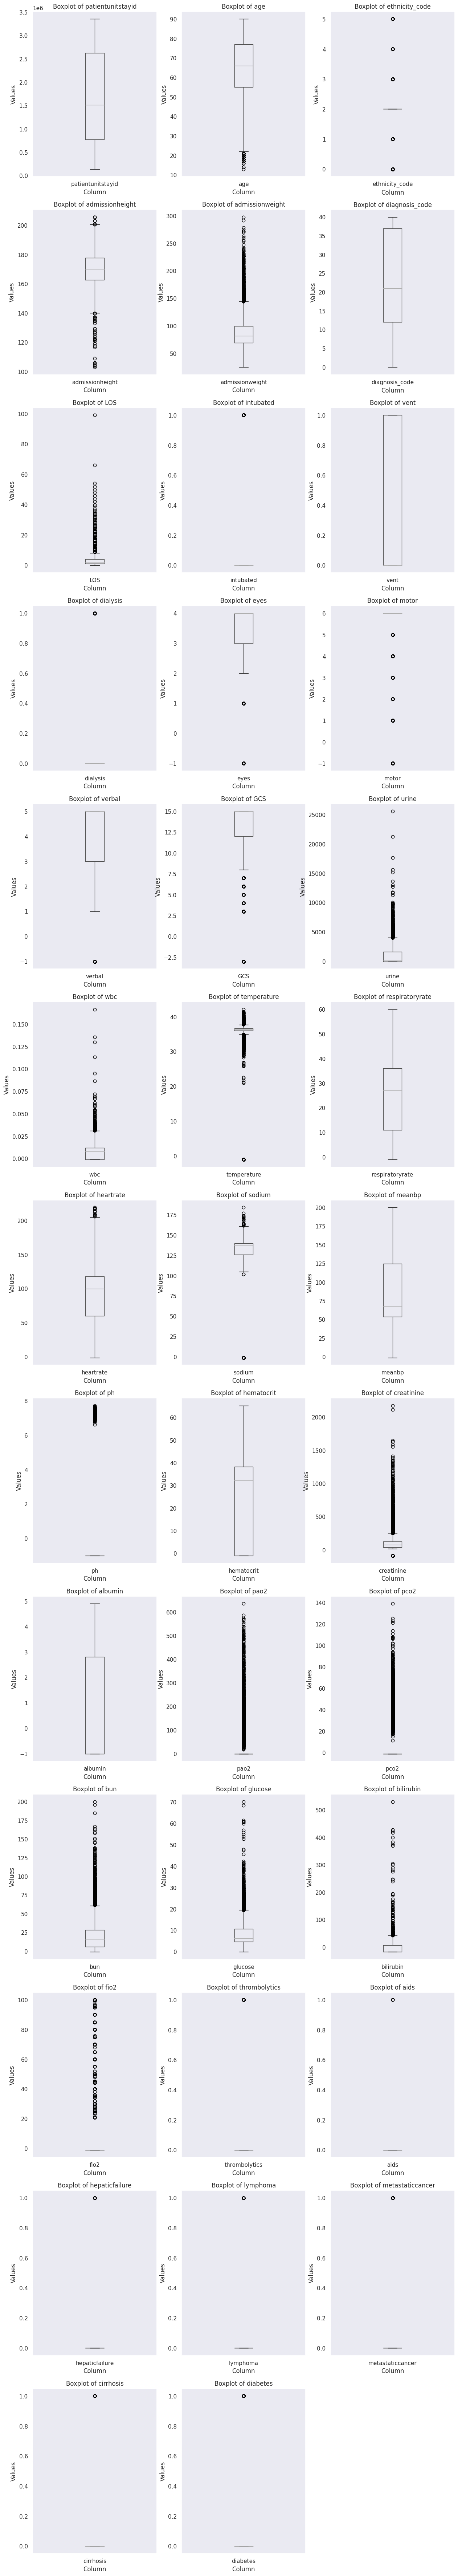

In [89]:
# Select numeric columns only
numeric_columns = df_cardiac.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_cardiac.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

#### Outliers less than 10 percentiles and `-1` values

In [92]:
# The -1 Values in several columns which denote for "no data was entered" were set to np.nan

# set the missing data to NaN
# lst_clms = ['eyes', 'motor', 'verbal', 'meds', 'urine', 'wbc',
#             'temperature', 'respiratoryrate', 'sodium',  'heartrate',
#             'ph', 'hematocrit', 'creatinine', 'albumin',
#             'pao2', 'pco2', 'bun', 'glucose', 'bilirubin', 'fio2']
# for clm in lst_clms:
#     df_cardiac.loc[df_cardiac[clm] == -1, [clm]] = np.nan

In [93]:
# column that consist of -1 values
negative_values = df_cardiac[(df_cardiac['eyes'] == -1) | (df_cardiac['motor'] == -1) | (df_cardiac['verbal'] == -1) |
                           (df_cardiac['urine'] == -1) | (df_cardiac['wbc'] == -1) | (df_cardiac['temperature'] == -1) |
                           (df_cardiac['respiratoryrate'] == -1) | (df_cardiac['sodium'] == -1) | (df_cardiac['heartrate'] == -1) |
                           (df_cardiac['meanbp'] == -1) | (df_cardiac['ph'] == -1) | (df_cardiac['hematocrit'] == -1) |
                           (df_cardiac['creatinine'] == -1) | (df_cardiac['albumin'] == -1) | (df_cardiac['pao2'] == -1) |
                           (df_cardiac['pco2'] == -1) | (df_cardiac['bun'] == -1) | (df_cardiac['glucose'] == -1) |
                           (df_cardiac['bilirubin'] == -1) | (df_cardiac['fio2'] == -1)]

len(negative_values)

13198

In [94]:
len(df_cardiac)

13891

##### **Visualize the `-1` values**



In [95]:
df_negative = df_cardiac.copy()

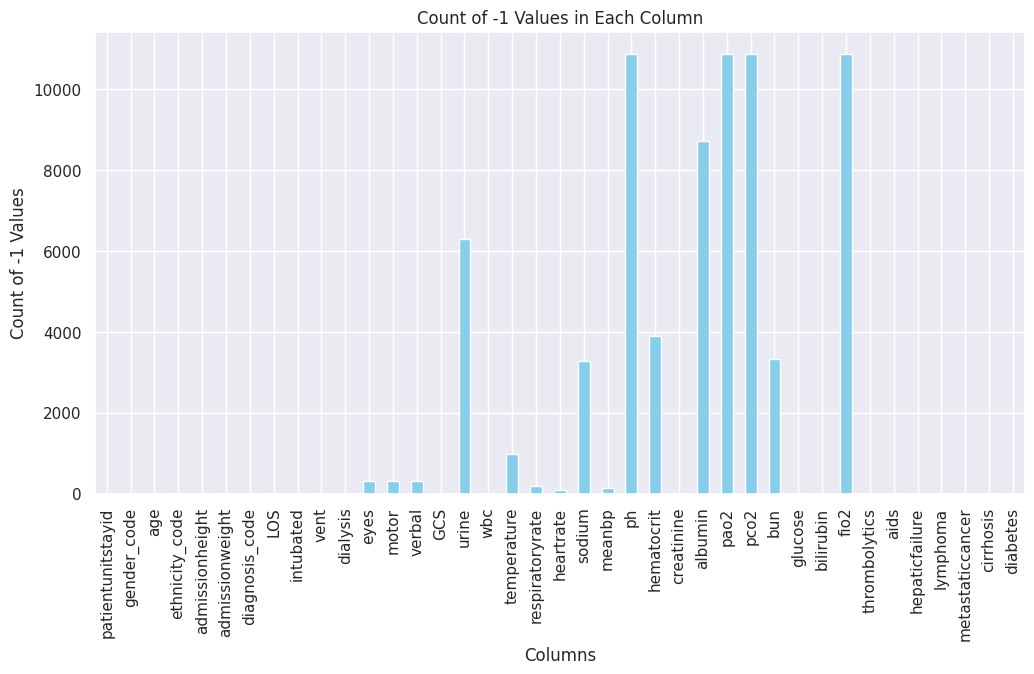

In [96]:
# Assuming df is your DataFrame with -1 representing missing values
# Replace -1 with NaN to prepare for visualization
df_negative.fillna(-1, inplace=True)

# Visualize the count of -1 values in each column
plt.figure(figsize=(12, 6))
missing_counts = df_negative.eq(-1).sum()
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Count of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Count of -1 Values')
plt.xticks(rotation=90)
plt.show()

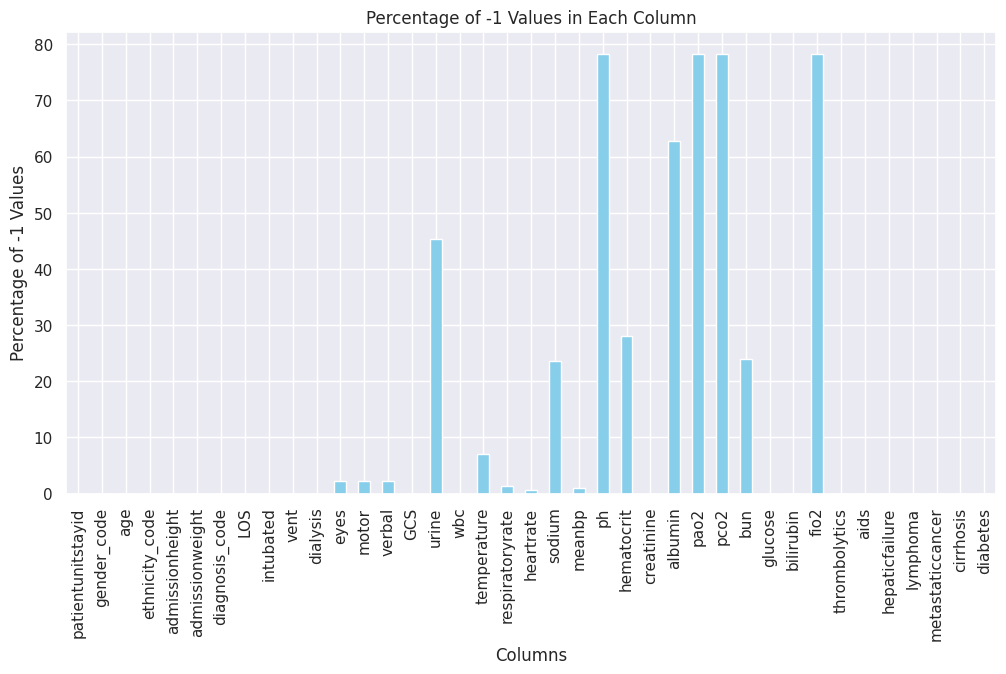

In [97]:
# Calculate the percentage of -1 values in each column
percentage_missing = (df_negative.eq(-1).sum() / len(df_negative)) * 100

# Visualize the percentage of -1 values in each column
plt.figure(figsize=(12, 6))
percentage_missing.plot(kind='bar', color='skyblue')
plt.title('Percentage of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of -1 Values')
plt.xticks(rotation=90)
plt.show()

##### **Solution 1 : Impute Missing Values using Univariate Approach**

In a Univariate approach, only a single feature is taken into consideration.

In [98]:
from sklearn.impute import SimpleImputer

# set the missing data to NaN
test_ua = df_cardiac.copy()
lst_clms = ['eyes', 'motor', 'verbal', 'urine', 'wbc',
            'temperature', 'respiratoryrate', 'sodium', 'meanbp', 'heartrate',
            'ph', 'hematocrit', 'creatinine', 'albumin',
            'pao2', 'pco2', 'bun', 'glucose', 'bilirubin', 'fio2']
for clm in lst_clms:
    test_ua.loc[test_ua[clm] == -1, [clm]] = np.nan

# Initialize SimpleImputer with strategy (mean, median, most_frequent, etc.)
imputer = SimpleImputer(strategy='mean')  # Mean as the imputation strategy

# Fit and transform the data with the imputer
imputed_data = imputer.fit_transform(test_ua)

# Convert the numpy array back to a pandas DataFrame
df_imputed_ua = pd.DataFrame(imputed_data, columns=test_ua.columns)
df_imputed_ua.describe(include='all')

,patientunitstayid,gender_code,age,ethnicity_code,admissionheight,admissionweight,diagnosis_code,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.389100e+04,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000
mean,1.635339e+06,0.428551,64.872579,1.919732,170.067312,86.415082,22.440645,3.296955,0.153841,0.289252,0.044129,3.412042,5.258428,4.010967,12.337125,1828.506929,0.007870,36.193047,25.531107,95.617168,138.125948,88.675386,7.343452,35.459592,87.181530,3.036408,130.790160,44.039561,26.593709,7.868124,-5.964368,63.787134,0.081996,0.000432,0.006191,0.003527,0.011158,0.006839,0.235116
std,1.018349e+06,0.494887,15.788843,0.968232,10.812925,26.661555,13.224374,3.756713,0.360809,0.453431,0.205390,1.062733,1.585292,1.592038,4.629438,1147.815803,0.008182,1.179413,14.833633,33.547387,4.399131,40.867032,0.056951,5.718811,162.880297,0.374536,41.639249,6.516834,17.102645,6.149668,21.209982,12.502502,0.274368,0.020779,0.078442,0.059290,0.105046,0.082418,0.424087
min,1.412290e+05,0.000000,13.000000,0.000000,103.000000,24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-3.000000,0.000000,-0.001000,21.000000,4.000000,20.000000,102.000000,40.000000,6.611000,7.700000,-88.400000,1.000000,17.000000,11.400000,2.000000,-0.055500,-17.100000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.788650e+05,0.000000,55.000000,2.000000,162.600000,69.095000,12.000000,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,4.000000,12.000000,1343.952000,-0.001000,36.193047,11.000000,60.000000,137.000000,55.000000,7.343452,33.000000,39.338000,3.036408,130.790160,44.039561,16.000000,4.773000,-17.100000,63.787134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.512837e+06,0.000000,66.000000,2.000000,170.200000,82.100000,21.000000,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1828.506929,0.007800,36.400000,27.000000,100.000000,138.125948,68.000000,7.343452,35.459592,78.676000,3.036408,130.790160,44.039561,26.593709,6.327000,-17.100000,63.787134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.624705e+06,1.000000,77.000000,2.000000,177.800000,99.300000,37.000000,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1828.506929,0.011900,36.700000,36.000000,118.000000,140.000000,125.000000,7.343452,38.300000,123.760000,3.036408,130.790160,44.039561,28.000000,10.656000,6.840000,63.787134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.353251e+06,1.000000,90.000000,5.000000,205.700000,297.700000,40.000000,99.000000,1.000000,1.000000,1.000000,4.000000,6.000000,5.000000,15.000000,25548.307200,0.166400,42.100000,60.000000,219.000000,184.000000,200.000000,7.715000,65.300000,2174.640000,4.900000,636.000000,139.000000,200.000000,70.096500,530.100000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


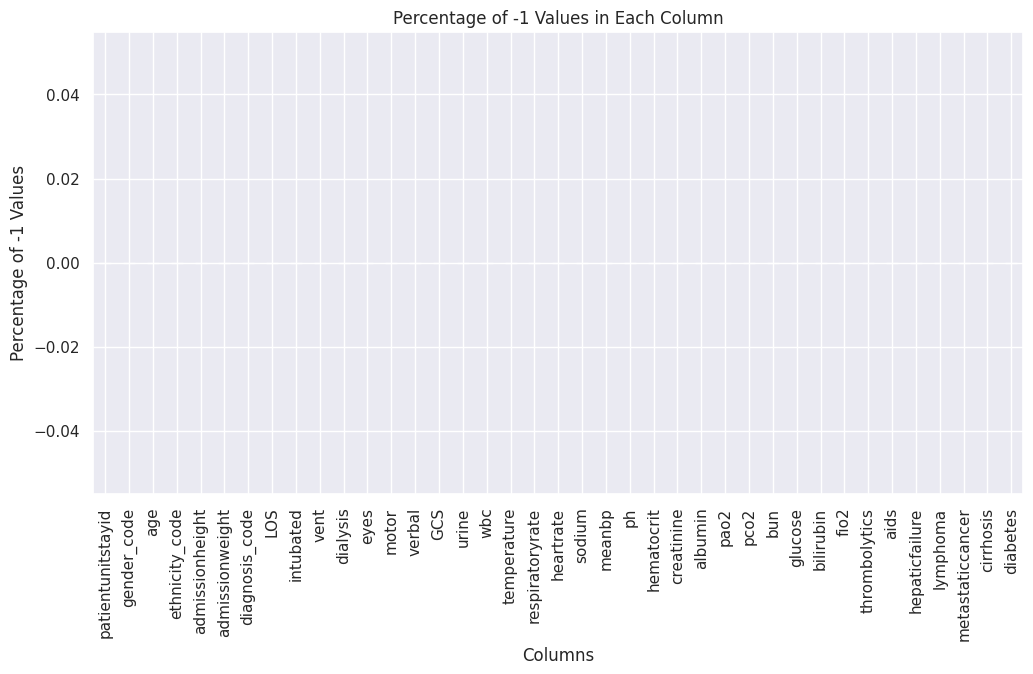

In [99]:
# Calculate the percentage of -1 values in each column
percentage_missing = (df_imputed_ua.eq(-1).sum() / len(df_imputed_ua)) * 100

# Visualize the percentage of -1 values in each column
plt.figure(figsize=(12, 6))
percentage_missing.plot(kind='bar', color='skyblue')
plt.title('Percentage of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of -1 Values')
plt.xticks(rotation=90)
plt.show()

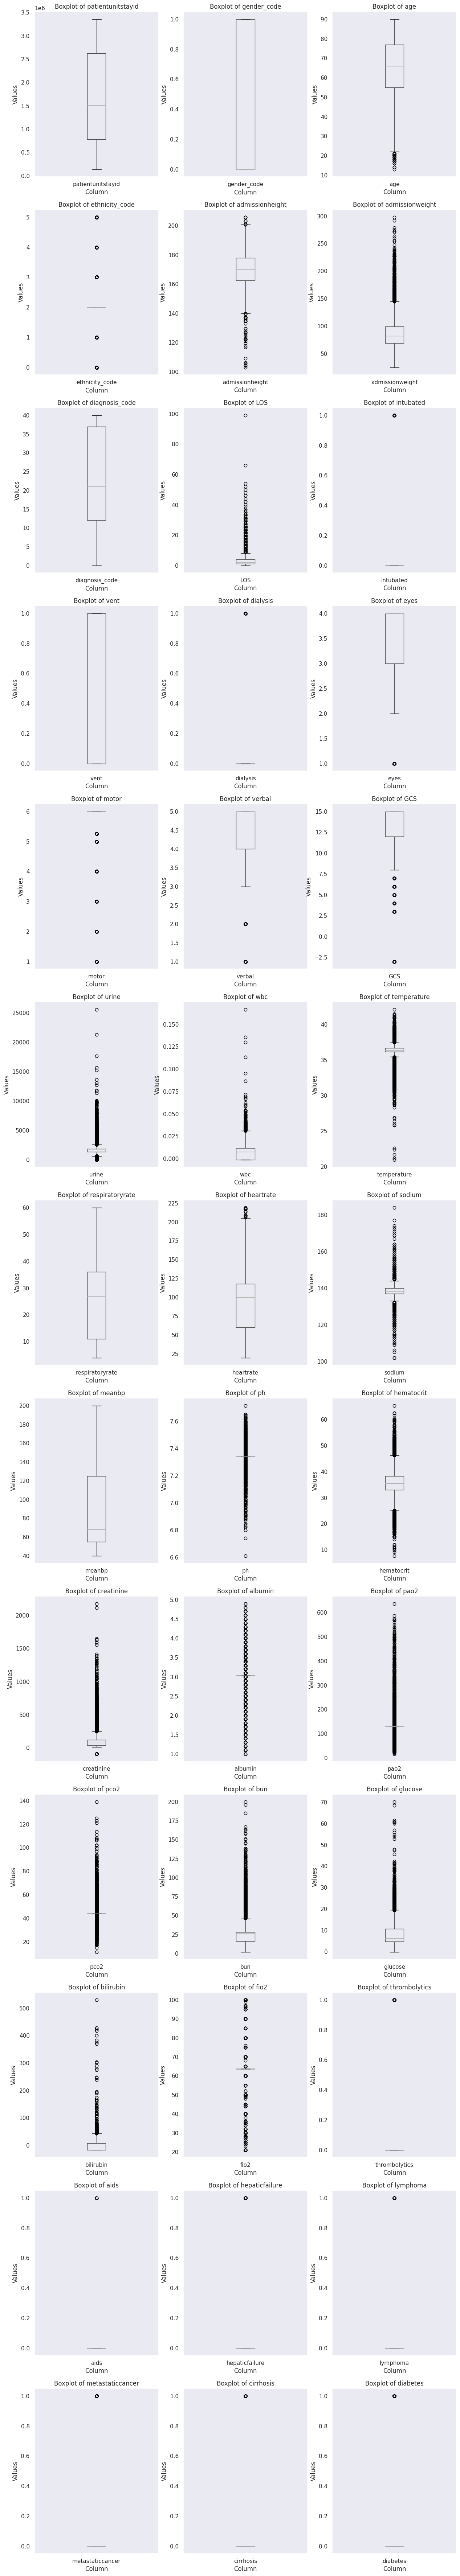

In [100]:
# Select numeric columns only
numeric_columns = df_imputed_ua.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_imputed_ua.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

##### **Solution *2* : Impute Missing Values using Multivariate Approach (IterativeImputer)**

In a multivariate approach, more than one feature is taken into consideration.

In [101]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# set the missing data to NaN
test_ii = df_cardiac.copy()
lst_clms = ['eyes', 'motor', 'verbal', 'urine', 'wbc',
            'temperature', 'respiratoryrate', 'sodium', 'meanbp', 'heartrate',
            'ph', 'hematocrit', 'creatinine', 'albumin',
            'pao2', 'pco2', 'bun', 'glucose', 'bilirubin', 'fio2']
for clm in lst_clms:
    test_ii.loc[test_ii[clm] == -1, [clm]] = np.nan

impute_it = IterativeImputer()
impute_it_data = impute_it.fit_transform(test_ii)


# Convert the numpy array back to a pandas DataFrame
df_imputed_ii = pd.DataFrame(impute_it_data, columns=test_ii.columns, index=test_ii.index)
df_imputed_ii.describe(include='all')

,patientunitstayid,gender_code,age,ethnicity_code,admissionheight,admissionweight,diagnosis_code,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.389100e+04,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000
mean,1.635339e+06,0.428551,64.872579,1.919732,170.067312,86.415082,22.440645,3.296955,0.153841,0.289252,0.044129,3.067730,5.258428,4.010967,12.337125,1795.900716,0.007870,36.193465,25.522642,95.584094,138.476641,88.661976,7.357391,35.831407,87.181530,3.128462,134.875483,46.014967,20.889910,7.868124,-5.964368,52.731906,0.081996,0.000432,0.006191,0.003527,0.011158,0.006839,0.235116
std,1.018349e+06,0.494887,15.788843,0.968232,10.812925,26.661555,13.224374,3.756713,0.360809,0.453431,0.205390,2.531904,1.585292,1.592038,4.629438,1180.898772,0.008182,1.190592,14.838464,33.553823,4.476522,40.870676,0.063150,5.905982,162.880297,0.435196,43.195146,7.065984,20.238037,6.149668,21.209982,14.730726,0.274368,0.020779,0.078442,0.059290,0.105046,0.082418,0.424087
min,1.412290e+05,0.000000,13.000000,0.000000,103.000000,24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.269395,1.000000,1.000000,-3.000000,-1325.945643,-0.001000,21.000000,4.000000,20.000000,102.000000,40.000000,6.611000,7.700000,-88.400000,1.000000,17.000000,11.400000,-33.794956,-0.055500,-17.100000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.788650e+05,0.000000,55.000000,2.000000,162.600000,69.095000,12.000000,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,4.000000,12.000000,1180.949976,-0.001000,36.100000,11.000000,60.000000,137.000000,55.000000,7.338888,32.700000,39.338000,2.912705,123.090125,43.927516,9.000000,4.773000,-17.100000,45.326371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.512837e+06,0.000000,66.000000,2.000000,170.200000,82.100000,21.000000,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1696.337913,0.007800,36.400000,27.000000,100.000000,139.000000,68.000000,7.361718,36.400000,78.676000,3.187417,135.346083,46.030026,16.000000,6.327000,-17.100000,49.734985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.624705e+06,1.000000,77.000000,2.000000,177.800000,99.300000,37.000000,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,2122.675200,0.011900,36.700000,36.000000,118.000000,140.318327,125.000000,7.384773,39.317031,123.760000,3.391100,145.040525,48.282699,28.000000,10.656000,6.840000,54.580796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.353251e+06,1.000000,90.000000,5.000000,205.700000,297.700000,40.000000,99.000000,1.000000,1.000000,1.000000,4.000000,6.000000,5.000000,15.000000,25548.307200,0.166400,42.100000,60.000000,219.000000,184.000000,200.000000,7.715000,65.300000,2174.640000,4.900000,636.000000,139.000000,200.000000,70.096500,530.100000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


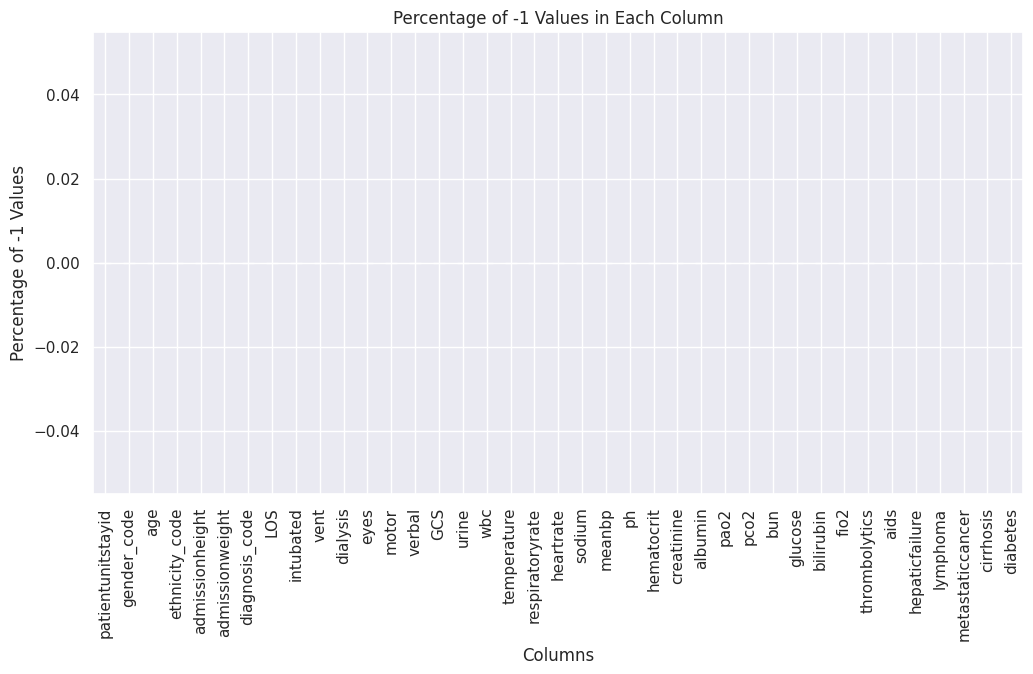

In [102]:
# Calculate the percentage of -1 values in each column
percentage_missing = (df_imputed_ii.eq(-1).sum() / len(df_imputed_ii)) * 100

# Visualize the percentage of -1 values in each column
plt.figure(figsize=(12, 6))
percentage_missing.plot(kind='bar', color='skyblue')
plt.title('Percentage of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of -1 Values')
plt.xticks(rotation=90)
plt.show()

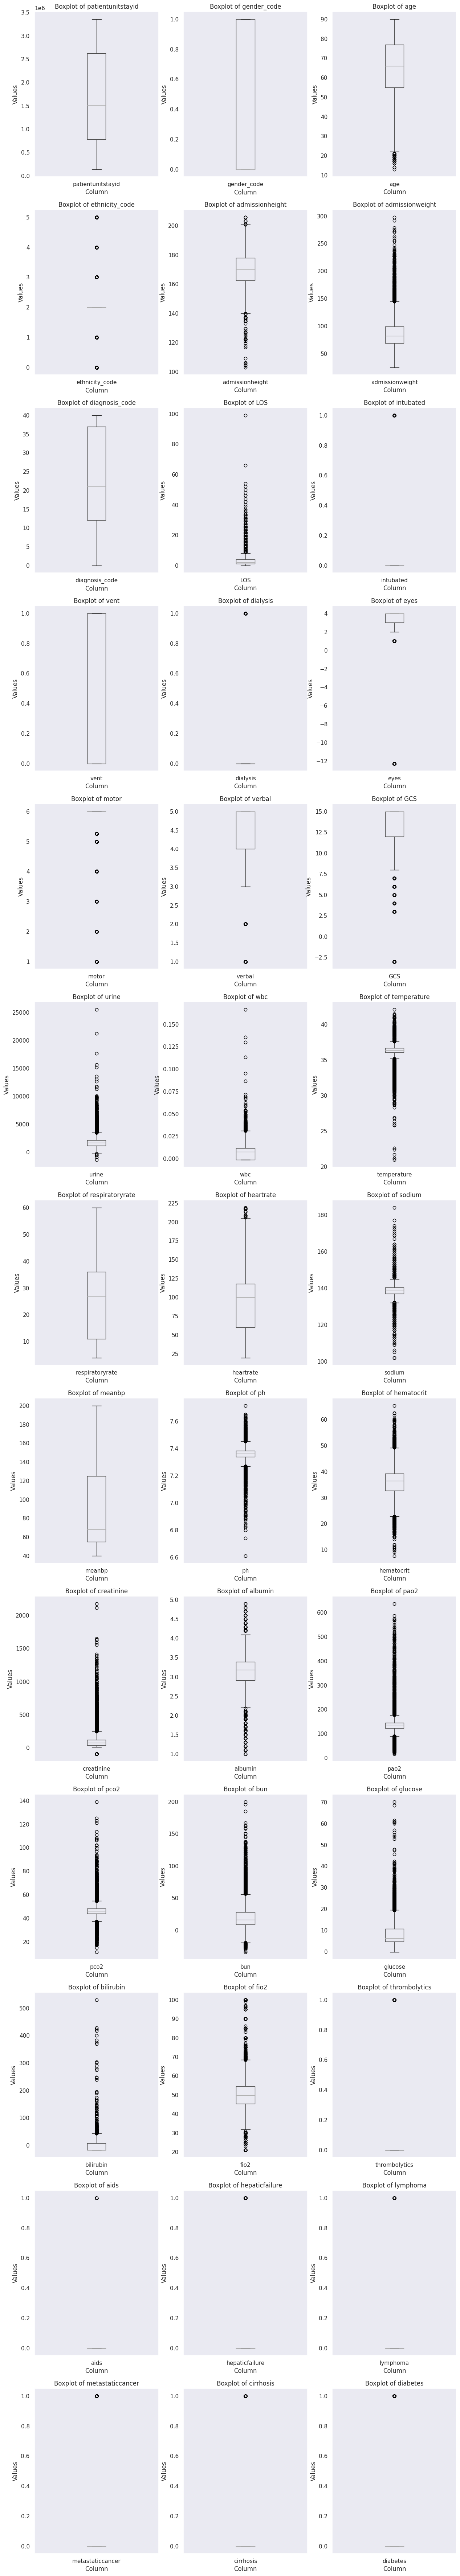

In [103]:
# Select numeric columns only
numeric_columns = df_imputed_ii.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_imputed_ii.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

##### **Solution *3* : Impute Missing Values using Multivariate Approach (KNNImputer)**

In a multivariate approach, more than one feature is taken into consideration.

In [104]:
from sklearn.impute import KNNImputer

# set the missing data to NaN
test_knn = df_cardiac.copy()
lst_clms = ['eyes', 'motor', 'verbal', 'urine', 'wbc',
            'temperature', 'respiratoryrate', 'sodium', 'meanbp', 'heartrate',
            'ph', 'hematocrit', 'creatinine', 'albumin',
            'pao2', 'pco2', 'bun', 'glucose', 'bilirubin', 'fio2']
for clm in lst_clms:
    test_knn.loc[test_knn[clm] == -1, [clm]] = np.nan

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Set the number of neighbors

# Fit and transform the data with the imputer
imputed_data = imputer.fit_transform(test_knn)

# Convert the numpy array back to a pandas DataFrame
df_imputed_knn = pd.DataFrame(imputed_data, columns=test_knn.columns, index=test_knn.index)
df_imputed_knn.describe(include='all')

,patientunitstayid,gender_code,age,ethnicity_code,admissionheight,admissionweight,diagnosis_code,LOS,intubated,vent,dialysis,eyes,motor,verbal,GCS,urine,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,cirrhosis,diabetes
count,1.389100e+04,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000,13891.000000
mean,1.635339e+06,0.428551,64.872579,1.919732,170.067312,86.415082,22.440645,3.296955,0.153841,0.289252,0.044129,3.411965,5.258095,4.010986,12.337125,1715.970984,0.007870,36.191134,25.528976,95.619207,138.158793,88.669742,7.343204,35.560359,87.181530,3.061556,127.230526,44.123559,26.136077,7.868124,-5.964368,63.172831,0.081996,0.000432,0.006191,0.003527,0.011158,0.006839,0.235116
std,1.018349e+06,0.494887,15.788843,0.968232,10.812925,26.661555,13.224374,3.756713,0.360809,0.453431,0.205390,1.065581,1.589464,1.596350,4.629438,1266.181172,0.008182,1.190282,14.859757,33.565573,4.553265,40.904388,0.077955,5.942846,162.880297,0.453733,55.166218,8.675785,17.597440,6.149668,21.209982,16.664512,0.274368,0.020779,0.078442,0.059290,0.105046,0.082418,0.424087
min,1.412290e+05,0.000000,13.000000,0.000000,103.000000,24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,-3.000000,0.000000,-0.001000,21.000000,4.000000,20.000000,102.000000,40.000000,6.611000,7.700000,-88.400000,1.000000,17.000000,11.400000,2.000000,-0.055500,-17.100000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.788650e+05,0.000000,55.000000,2.000000,162.600000,69.095000,12.000000,1.000000,0.000000,0.000000,0.000000,3.000000,6.000000,4.000000,12.000000,860.803200,-0.001000,36.100000,11.000000,60.000000,136.000000,55.000000,7.303200,32.150000,39.338000,2.800000,90.200000,38.700000,15.000000,4.773000,-17.100000,51.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.512837e+06,0.000000,66.000000,2.000000,170.200000,82.100000,21.000000,2.000000,0.000000,0.000000,0.000000,4.000000,6.000000,5.000000,15.000000,1514.678400,0.007800,36.400000,27.000000,100.000000,138.000000,68.000000,7.350000,35.840000,78.676000,3.080000,115.000000,43.200000,21.000000,6.327000,-17.100000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.624705e+06,1.000000,77.000000,2.000000,177.800000,99.300000,37.000000,4.000000,0.000000,1.000000,0.000000,4.000000,6.000000,5.000000,15.000000,2200.374720,0.011900,36.700000,36.000000,118.000000,140.200000,125.000000,7.390400,39.200000,123.760000,3.340000,148.800000,48.320000,31.200000,10.656000,6.840000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.353251e+06,1.000000,90.000000,5.000000,205.700000,297.700000,40.000000,99.000000,1.000000,1.000000,1.000000,4.000000,6.000000,5.000000,15.000000,25548.307200,0.166400,42.100000,60.000000,219.000000,184.000000,200.000000,7.715000,65.300000,2174.640000,4.900000,636.000000,139.000000,200.000000,70.096500,530.100000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


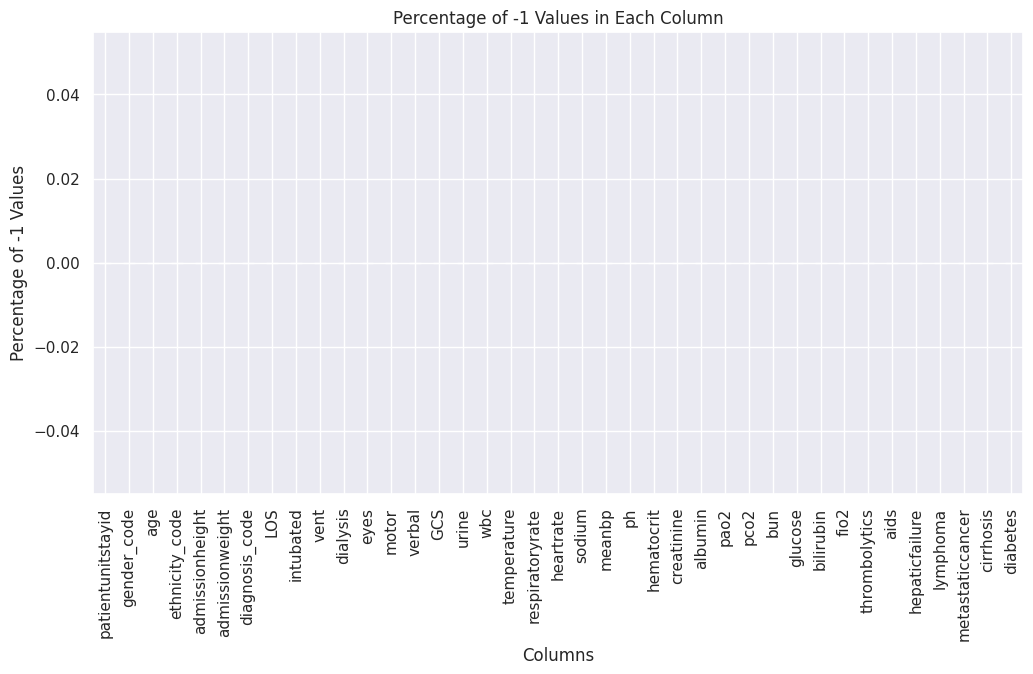

In [105]:
# Calculate the percentage of -1 values in each column
percentage_missing = (df_imputed_knn.eq(-1).sum() / len(df_imputed_knn)) * 100

# Visualize the percentage of -1 values in each column
plt.figure(figsize=(12, 6))
percentage_missing.plot(kind='bar', color='skyblue')
plt.title('Percentage of -1 Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of -1 Values')
plt.xticks(rotation=90)
plt.show()

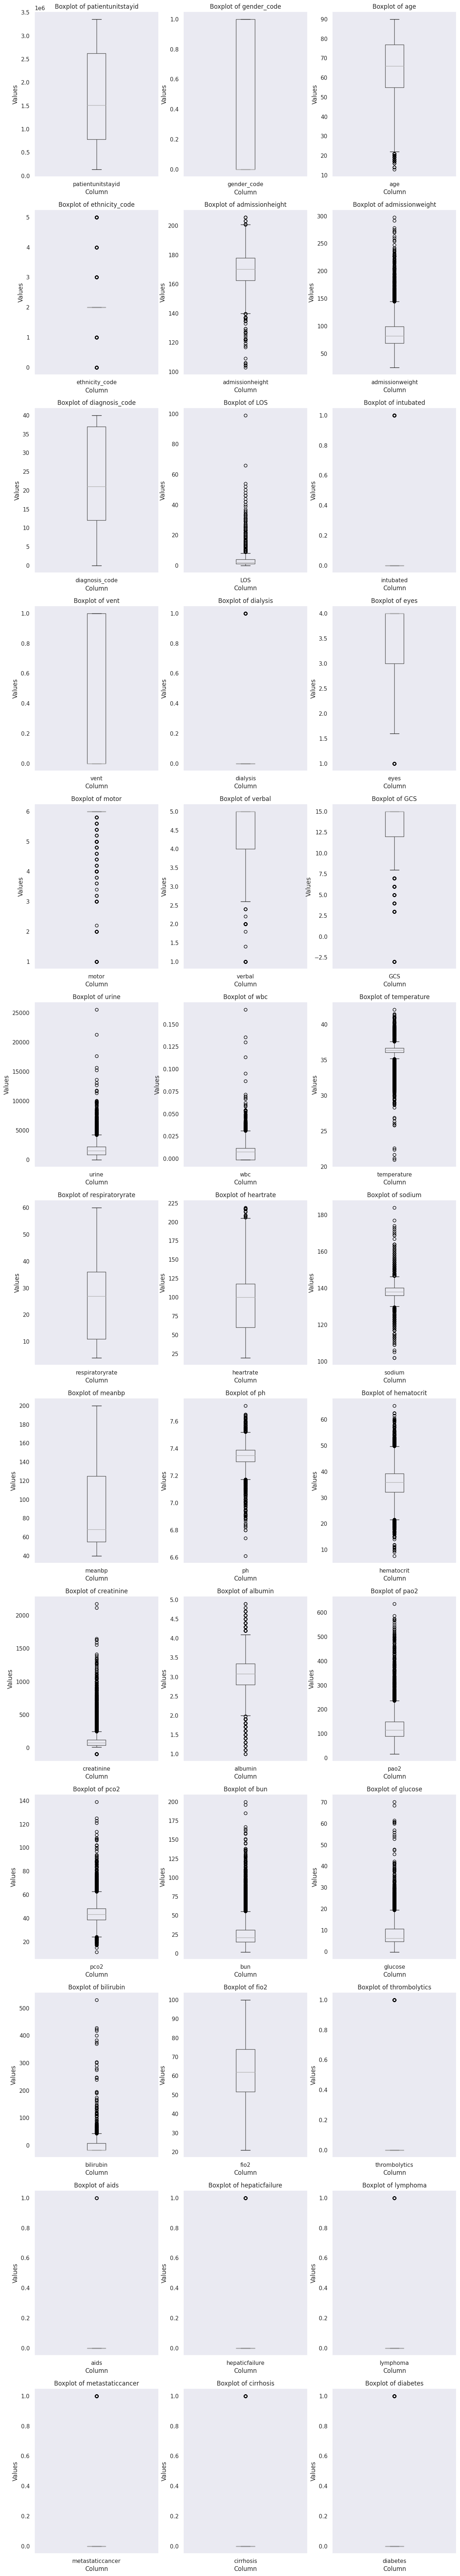

In [106]:
# Select numeric columns only
numeric_columns = df_imputed_knn.select_dtypes(include=['number']).columns

# Calculate number of rows needed for subplots
num_cols = len(numeric_columns)
num_rows = (num_cols // 3) + (num_cols % 3)

# Create boxplots for numeric columns
plt.figure(figsize=(15, 7 * num_rows))
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, 3, i)
    df_imputed_knn.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Values')
    plt.xlabel('Column')
    plt.grid(False)

urine, wbc, cratinine, glucose, bilirubin